In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
def plot_cwts(instances, images_per_row=10, **options):
    size = 100
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
# Code example
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


from scipy import signal
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [54]:
eyes_closed_time_data = pd.read_csv("C:\\Users\\mmang\\source\\repos\\MindGamesApi\\MindGamesApi\\Jupyter Notebooks\\datasets\\CWT_DATA_mock_alpha_7_21.csv", thousands=',')
eyes_open_time_data = pd.read_csv("C:\\Users\\mmang\\source\\repos\\MindGamesApi\\MindGamesApi\\Jupyter Notebooks\\datasets\\CWT_DATA_mock_non_alpha_7_21.csv", thousands=',')

eyes_open_time_data = eyes_open_time_data[:10000]
eyes_closed_time_data = eyes_closed_time_data[:10000]
eyes_open_time_data

,Channel,10-20,ChannelGroup,Volts,TimeStamp
0,1,P4,7d28f4f5-5930-4ba6-a0f3-16c0713d461a,0.211915,22927
1,2,POz,7d28f4f5-5930-4ba6-a0f3-16c0713d461a,0.143774,22927
2,3,PO4,7d28f4f5-5930-4ba6-a0f3-16c0713d461a,0.170428,22927
3,4,O2,7d28f4f5-5930-4ba6-a0f3-16c0713d461a,0.040160,22927
4,5,O1,7d28f4f5-5930-4ba6-a0f3-16c0713d461a,-0.111918,22927
...,...,...,...,...,...
9995,4,O2,b2e0beff-6273-4f88-9b25-356be2b1f430,-0.040019,28037
9996,5,O1,b2e0beff-6273-4f88-9b25-356be2b1f430,-0.000881,28037
9997,6,Oz,b2e0beff-6273-4f88-9b25-356be2b1f430,0.314691,28037
9998,7,PO3,b2e0beff-6273-4f88-9b25-356be2b1f430,0.704765,28037


In [55]:
fs = 250.0
lowcut = 5.0
highcut = 15.0

filtered_eyes_open_channel_data = pd.DataFrame([])
channel_group_data = eyes_open_time_data.groupby(['Channel'])
for name, channel_group in channel_group_data:
    channel_df = pd.DataFrame(channel_group.values)
    volts = channel_df[3]
    filtered_volts = butter_bandpass_filter(list(volts), lowcut, highcut, fs)
    channel_df['Filtered Volts'] = filtered_volts
    filtered_eyes_open_channel_data = filtered_eyes_open_channel_data.append(channel_df)
#pd.DataFrame(filtered_channel_data)

filtered_eyes_open_channel_data.columns = ['Channel', '10-20', 'ChannelGroup', 'Volts', 'TimeStamp', 'Filtered Volts']


filtered_eyes_closed_channel_data = pd.DataFrame([])
channel_group_data2 = eyes_closed_time_data.groupby(['Channel'])
for name, channel_group in channel_group_data2:
    channel_df = pd.DataFrame(channel_group.values)
    volts = channel_df[3]
    filtered_volts = butter_bandpass_filter(list(volts), lowcut, highcut, fs)
    channel_df['Filtered Volts'] = filtered_volts
    filtered_eyes_closed_channel_data = filtered_eyes_closed_channel_data.append(channel_df)
#pd.DataFrame(filtered_channel_data)

filtered_eyes_closed_channel_data.columns = ['Channel', '10-20', 'ChannelGroup', 'Volts', 'TimeStamp', 'Filtered Volts']

In [56]:
channel_group_data_eyes_open = filtered_eyes_open_channel_data.groupby(['ChannelGroup', 'TimeStamp'])
channel_group_data_eyes_closed = filtered_eyes_closed_channel_data.groupby(['ChannelGroup', 'TimeStamp'])



In [57]:
#remove tuple ranking
period_group_cleaned = [item[1] for item in channel_group_data_eyes_closed]
period_channel_groups = pd.DataFrame([])

#make a master df of all channels for this period
for channel_group in period_group_cleaned:
    channel_group_df = pd.DataFrame(channel_group)
    period_channel_groups = period_channel_groups.append(channel_group_df)
    
#remove tuple ranking
period_group_cleaned2 = [item[1] for item in channel_group_data_eyes_open]
period_channel_groups2 = pd.DataFrame([])

#make a master df of all channels for this period
for channel_group in period_group_cleaned2:
    channel_group_df = pd.DataFrame(channel_group)
    period_channel_groups2 = period_channel_groups2.append(channel_group_df)

period_channel_groups2

,Channel,10-20,ChannelGroup,Volts,TimeStamp,Filtered Volts
164,1,P4,0067c9b2-a212-41cb-a16f-b8010e463286,-0.223691,23617,-0.080607
164,2,POz,0067c9b2-a212-41cb-a16f-b8010e463286,-0.064812,23617,0.002456
164,3,PO4,0067c9b2-a212-41cb-a16f-b8010e463286,0.22105,23617,0.322929
164,4,O2,0067c9b2-a212-41cb-a16f-b8010e463286,0.338481,23617,0.443464
164,5,O1,0067c9b2-a212-41cb-a16f-b8010e463286,-0.322919,23617,-0.090081
...,...,...,...,...,...,...
384,4,O2,ffe6296c-58c6-4df2-bd04-bea88902a8e8,-0.050596,24522,0.119210
384,5,O1,ffe6296c-58c6-4df2-bd04-bea88902a8e8,-0.076002,24522,-0.019579
384,6,Oz,ffe6296c-58c6-4df2-bd04-bea88902a8e8,-0.589226,24522,-0.091808
384,7,PO3,ffe6296c-58c6-4df2-bd04-bea88902a8e8,-0.417127,24522,-0.322012


In [58]:
period_channel_groups

,Channel,10-20,ChannelGroup,Volts,TimeStamp,Filtered Volts
136,1,P4,0072d965-aca1-4972-b181-5a7a4ba0c166,-0.259466,45789,-0.681490
136,2,POz,0072d965-aca1-4972-b181-5a7a4ba0c166,1.009086,45789,0.914934
136,3,PO4,0072d965-aca1-4972-b181-5a7a4ba0c166,-0.43293,45789,-0.378257
136,4,O2,0072d965-aca1-4972-b181-5a7a4ba0c166,-0.728216,45789,-0.599943
136,5,O1,0072d965-aca1-4972-b181-5a7a4ba0c166,0.013795,45789,0.414785
...,...,...,...,...,...,...
830,4,O2,ff998618-f26a-40a6-9ee0-9aa9f52535cf,-0.270627,48764,0.394787
830,5,O1,ff998618-f26a-40a6-9ee0-9aa9f52535cf,-0.279787,48764,-0.660821
830,6,Oz,ff998618-f26a-40a6-9ee0-9aa9f52535cf,0.560571,48764,0.218149
830,7,PO3,ff998618-f26a-40a6-9ee0-9aa9f52535cf,0.119389,48764,-0.409785


In [59]:
period_channel_groups_sorted_eyes_closed = period_channel_groups.sort_values(['TimeStamp', 'Channel'])
period_channel_groups_sorted_eyes_open = period_channel_groups2.sort_values(['TimeStamp', 'Channel'])
period_channel_groups_sorted_eyes_closed

,Channel,10-20,ChannelGroup,Volts,TimeStamp,Filtered Volts
0,1,P4,a16f6a93-0647-492e-8e73-4948c1650c4a,0.151174,45209,0.002020
0,2,POz,a16f6a93-0647-492e-8e73-4948c1650c4a,-0.467913,45209,-0.006251
0,3,PO4,a16f6a93-0647-492e-8e73-4948c1650c4a,-0.764767,45209,-0.010217
0,4,O2,a16f6a93-0647-492e-8e73-4948c1650c4a,-0.471746,45209,-0.006302
0,5,O1,a16f6a93-0647-492e-8e73-4948c1650c4a,0.150509,45209,0.002011
...,...,...,...,...,...,...
1249,4,O2,0b0ddb5c-102a-46cd-9d26-80548af17934,-0.054879,50731,-0.493104
1249,5,O1,0b0ddb5c-102a-46cd-9d26-80548af17934,0.816469,50731,0.858966
1249,6,Oz,0b0ddb5c-102a-46cd-9d26-80548af17934,-0.606172,50731,-0.042692
1249,7,PO3,0b0ddb5c-102a-46cd-9d26-80548af17934,0.668151,50731,0.503831


In [60]:
channels_closed = period_channel_groups_sorted_eyes_closed.groupby(['Channel'])
channels_open = period_channel_groups_sorted_eyes_open.groupby(['Channel'])

In [61]:
channels_closed

In [62]:
channel_1_data_closed = channels_closed.get_group(1)
channel_2_data_closed = channels_closed.get_group(2)
channel_3_data_closed = channels_closed.get_group(3)
channel_4_data_closed = channels_closed.get_group(4)
channel_5_data_closed = channels_closed.get_group(5)
channel_6_data_closed = channels_closed.get_group(6)
channel_7_data_closed = channels_closed.get_group(7)
channel_8_data_closed = channels_closed.get_group(8)

channel_1_data_open = channels_open.get_group(1)
channel_2_data_open = channels_open.get_group(2)
channel_3_data_open = channels_open.get_group(3)
channel_4_data_open = channels_open.get_group(4)
channel_5_data_open = channels_open.get_group(5)
channel_6_data_open = channels_open.get_group(6)
channel_7_data_open = channels_open.get_group(7)
channel_8_data_open = channels_open.get_group(8)

In [63]:
channel_1_data_sorted_closed = channel_1_data_closed.sort_index(0)
channel_2_data_sorted_closed = channel_2_data_closed.sort_index(0)
channel_3_data_sorted_closed = channel_3_data_closed.sort_index(0)
channel_4_data_sorted_closed = channel_4_data_closed.sort_index(0)
channel_5_data_sorted_closed = channel_5_data_closed.sort_index(0)
channel_6_data_sorted_closed = channel_6_data_closed.sort_index(0)
channel_7_data_sorted_closed = channel_7_data_closed.sort_index(0)
channel_8_data_sorted_closed = channel_8_data_closed.sort_index(0)

channel_1_data_sorted_open = channel_1_data_open.sort_index(0)
channel_2_data_sorted_open = channel_2_data_open.sort_index(0)
channel_3_data_sorted_open = channel_3_data_open.sort_index(0)
channel_4_data_sorted_open = channel_4_data_open.sort_index(0)
channel_5_data_sorted_open = channel_5_data_open.sort_index(0)
channel_6_data_sorted_open = channel_6_data_open.sort_index(0)
channel_7_data_sorted_open = channel_7_data_open.sort_index(0)
channel_8_data_sorted_open = channel_8_data_open.sort_index(0)


c:\users\mmang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  """Entry point for launching an IPython kernel.
c:\users\mmang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  
c:\users\mmang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\mmang\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  after removing the cwd from sys.path.
c:\users\mmang\appdat

In [64]:
period_data_eyes_open = []
channel_1_periods_eyes_open = list(grouper(channel_1_data_sorted_open.values, 1000))[:-1]
channel_2_periods_eyes_open = list(grouper(channel_2_data_sorted_open.values, 1000))[:-1]
channel_3_periods_eyes_open = list(grouper(channel_3_data_sorted_open.values, 1000))[:-1]
channel_4_periods_eyes_open = list(grouper(channel_4_data_sorted_open.values, 1000))[:-1]
channel_5_periods_eyes_open = list(grouper(channel_5_data_sorted_open.values, 1000))[:-1]
channel_6_periods_eyes_open = list(grouper(channel_6_data_sorted_open.values, 1000))[:-1]
channel_7_periods_eyes_open = list(grouper(channel_7_data_sorted_open.values, 1000))[:-1]
channel_8_periods_eyes_open = list(grouper(channel_8_data_sorted_open.values, 1000))[:-1]

channels_periods_eyes_open = [
    channel_1_periods_eyes_open,
    channel_2_periods_eyes_open,
    channel_3_periods_eyes_open,
    channel_4_periods_eyes_open,
    channel_5_periods_eyes_open,
    channel_6_periods_eyes_open,
    channel_7_periods_eyes_open,
    channel_8_periods_eyes_open
]

period_data_eyes_closed = []
channel_1_periods_eyes_closed = list(grouper(channel_1_data_sorted_closed.values, 1000))[:-1]
channel_2_periods_eyes_closed = list(grouper(channel_2_data_sorted_closed.values, 1000))[:-1]
channel_3_periods_eyes_closed = list(grouper(channel_3_data_sorted_closed.values, 1000))[:-1]
channel_4_periods_eyes_closed = list(grouper(channel_4_data_sorted_closed.values, 1000))[:-1]
channel_5_periods_eyes_closed = list(grouper(channel_5_data_sorted_closed.values, 1000))[:-1]
channel_6_periods_eyes_closed = list(grouper(channel_6_data_sorted_closed.values, 1000))[:-1]
channel_7_periods_eyes_closed = list(grouper(channel_7_data_sorted_closed.values, 1000))[:-1]
channel_8_periods_eyes_closed = list(grouper(channel_8_data_sorted_closed.values, 1000))[:-1]

channels_periods_eyes_closed = [
    channel_1_periods_eyes_closed,
    channel_2_periods_eyes_closed,
    channel_3_periods_eyes_closed,
    channel_4_periods_eyes_closed,
    channel_5_periods_eyes_closed,
    channel_6_periods_eyes_closed,
    channel_7_periods_eyes_closed,
    channel_8_periods_eyes_closed
]



In [70]:
cwt_data_eyes_open = []
cwt_labels_eyes_open = []

cwt_data_eyes_closed = []
cwt_labels_eyes_closed = []

widths = np.linspace(1.0, 15.0, 1000);

for index, period in enumerate(channel_1_periods_eyes_closed):
    all_channels_cwt_flattened_closed = []
    
    flattened_volts_1 = []
    flattened_volts_2 = []
    flattened_volts_3 = []
    flattened_volts_4 = []
    flattened_volts_5 = []
    flattened_volts_6 = []
    flattened_volts_7 = []
    flattened_volts_8 = []
    
    for row in period:
        flattened_volts_1 = pd.DataFrame(channels_periods_eyes_closed[0][index])[3]
        flattened_volts_2 = pd.DataFrame(channels_periods_eyes_closed[1][index])[3]
        flattened_volts_3 = pd.DataFrame(channels_periods_eyes_closed[2][index])[3]
        flattened_volts_4 = pd.DataFrame(channels_periods_eyes_closed[3][index])[3]
        flattened_volts_5 = pd.DataFrame(channels_periods_eyes_closed[4][index])[3]
        flattened_volts_6 = pd.DataFrame(channels_periods_eyes_closed[5][index])[3]
        flattened_volts_7 = pd.DataFrame(channels_periods_eyes_closed[6][index])[3]
        flattened_volts_8 = pd.DataFrame(channels_periods_eyes_closed[7][index])[3]
            
    cwt_1 = signal.cwt(flattened_volts_1, signal.ricker, widths)
    cwt_2 = signal.cwt(flattened_volts_2, signal.ricker, widths)
    cwt_3 = signal.cwt(flattened_volts_3, signal.ricker, widths)
    cwt_4 = signal.cwt(flattened_volts_4, signal.ricker, widths)
    cwt_5 = signal.cwt(flattened_volts_5, signal.ricker, widths)
    cwt_6 = signal.cwt(flattened_volts_6, signal.ricker, widths)
    cwt_7 = signal.cwt(flattened_volts_7, signal.ricker, widths)
    cwt_8 = signal.cwt(flattened_volts_8, signal.ricker, widths)
    
    cwt_1_flattened = cwt_1.flatten()
    cwt_2_flattened = cwt_2.flatten()
    cwt_3_flattened = cwt_3.flatten()
    cwt_4_flattened = cwt_4.flatten()
    cwt_5_flattened = cwt_5.flatten()
    cwt_6_flattened = cwt_6.flatten()
    cwt_7_flattened = cwt_7.flatten()
    cwt_8_flattened = cwt_8.flatten()
    
    all_channels_cwt_flattened_closed = all_channels_cwt_flattened_closed + list(cwt_1_flattened) + list(cwt_2_flattened) + list(cwt_3_flattened) + list(cwt_4_flattened) + list(cwt_5_flattened) + list(cwt_6_flattened) + list(cwt_7_flattened) + list(cwt_8_flattened)
    
    cwt_data_eyes_closed.append(all_channels_cwt_flattened_closed)

In [71]:
for index, period in enumerate(channel_1_periods_eyes_open):
    all_channels_cwt_flattened_open = []
    
    flattened_volts_1 = []
    flattened_volts_2 = []
    flattened_volts_3 = []
    flattened_volts_4 = []
    flattened_volts_5 = []
    flattened_volts_6 = []
    flattened_volts_7 = []
    flattened_volts_8 = []
    
    for row in period:
        flattened_volts_1 = pd.DataFrame(channels_periods_eyes_open[0][index])[3]
        flattened_volts_2 = pd.DataFrame(channels_periods_eyes_open[1][index])[3]
        flattened_volts_3 = pd.DataFrame(channels_periods_eyes_open[2][index])[3]
        flattened_volts_4 = pd.DataFrame(channels_periods_eyes_open[3][index])[3]
        flattened_volts_5 = pd.DataFrame(channels_periods_eyes_open[4][index])[3]
        flattened_volts_6 = pd.DataFrame(channels_periods_eyes_open[5][index])[3]
        flattened_volts_7 = pd.DataFrame(channels_periods_eyes_open[6][index])[3]
        flattened_volts_8 = pd.DataFrame(channels_periods_eyes_open[7][index])[3]
            
    cwt_1 = signal.cwt(flattened_volts_1, signal.ricker, widths)
    cwt_2 = signal.cwt(flattened_volts_2, signal.ricker, widths)
    cwt_3 = signal.cwt(flattened_volts_3, signal.ricker, widths)
    cwt_4 = signal.cwt(flattened_volts_4, signal.ricker, widths)
    cwt_5 = signal.cwt(flattened_volts_5, signal.ricker, widths)
    cwt_6 = signal.cwt(flattened_volts_6, signal.ricker, widths)
    cwt_7 = signal.cwt(flattened_volts_7, signal.ricker, widths)
    cwt_8 = signal.cwt(flattened_volts_8, signal.ricker, widths)
    
    cwt_1_flattened = cwt_1.flatten()
    cwt_2_flattened = cwt_2.flatten()
    cwt_3_flattened = cwt_3.flatten()
    cwt_4_flattened = cwt_4.flatten()
    cwt_5_flattened = cwt_5.flatten()
    cwt_6_flattened = cwt_6.flatten()
    cwt_7_flattened = cwt_7.flatten()
    cwt_8_flattened = cwt_8.flatten()
    
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_1_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_2_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_3_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_4_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_5_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_6_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_7_flattened);
    all_channels_cwt_flattened_open = all_channels_cwt_flattened_open + list(cwt_8_flattened);
    
    cwt_data_eyes_open.append(all_channels_cwt_flattened_open)

In [72]:
len(cwt_data_eyes_open[0])

8000000

Saving figure some_cwt_plot


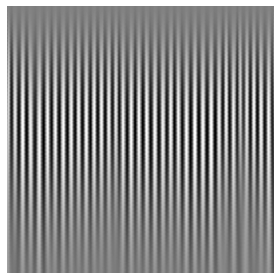

In [73]:
some_cwt = pd.DataFrame(cwt_data_eyes_closed[0][1000000:2000000])
some_cwt_image = some_cwt.values.reshape(1000, 1000)
plt.imshow(some_cwt_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_cwt_plot")
plt.show()

Saving figure some_cwt_plot


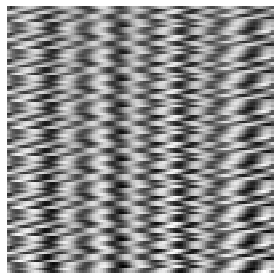

In [74]:
some_cwt = pd.DataFrame(cwt_data_eyes_open[0][20000:30000])
some_cwt_image = some_cwt.values.reshape(100, 100)
plt.imshow(some_cwt_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_cwt_plot")
plt.show()

In [40]:
eyes_open_labels = []
eyes_closed_labels = []

for cwt_row in cwt_data_eyes_open:
    eyes_open_labels.append(False)
for cwt_row in cwt_data_eyes_closed:
    eyes_closed_labels.append(True)
    
eyes_open_labels = pd.DataFrame(eyes_open_labels)
eyes_closed_labels = pd.DataFrame(eyes_closed_labels)
eyes_open_labels

,0
0,False
1,False
2,False
3,False
4,False
5,False


In [41]:
cwt_data_eyes_open_df = pd.DataFrame(cwt_data_eyes_open)
cwt_data_eyes_closed_df = pd.DataFrame(cwt_data_eyes_closed)

mock_data = pd.concat([cwt_data_eyes_open_df, cwt_data_eyes_closed_df])
mock_data_labels = pd.concat([eyes_open_labels, eyes_closed_labels])

mock_data

,0,1,2,3,4,5,6,7,8,9,...,79990,79991,79992,79993,79994,79995,79996,79997,79998,79999
0,0.102910,0.226920,0.082203,0.006039,-0.019927,-0.050879,-0.086665,-0.115653,-0.125224,-0.108959,...,-0.094670,-0.040341,0.018071,0.076857,0.133316,0.185866,0.233855,0.277287,0.316617,0.352539
1,0.096902,0.132616,0.017412,-0.068638,-0.110960,-0.123090,-0.105016,-0.061160,-0.002083,0.056808,...,0.000237,-0.013054,-0.021252,-0.024976,-0.025952,-0.026565,-0.029452,-0.037052,-0.050983,-0.071294
2,-0.006206,-0.224875,-0.165489,-0.075415,0.000229,0.069844,0.116182,0.126758,0.101231,0.048666,...,-0.355835,-0.367400,-0.369908,-0.364614,-0.353889,-0.340905,-0.328967,-0.320676,-0.317304,-0.318537
3,0.056117,0.038490,0.029664,0.017721,-0.010043,-0.050130,-0.092643,-0.126051,-0.139854,-0.127415,...,-0.276849,-0.267546,-0.260052,-0.257284,-0.260665,-0.269439,-0.280462,-0.288818,-0.289322,-0.278561
4,0.048850,0.147697,0.107055,0.043763,-0.017062,-0.076510,-0.124836,-0.151956,-0.151038,-0.120664,...,-0.356426,-0.344496,-0.333463,-0.326218,-0.324162,-0.326560,-0.330328,-0.330623,-0.322331,-0.302125
5,0.149007,0.288879,0.038214,-0.115651,-0.160838,-0.160032,-0.123260,-0.059964,0.015261,0.085305,...,-0.163685,-0.151019,-0.126752,-0.095123,-0.062550,-0.036094,-0.021506,-0.021533,-0.035064,-0.057299
0,0.166618,0.254281,0.082267,-0.002626,-0.028423,-0.054626,-0.084219,-0.111263,-0.130268,-0.137907,...,-0.444941,-0.517004,-0.589074,-0.654449,-0.706721,-0.740637,-0.752952,-0.742964,-0.712622,-0.666260
1,0.099283,-0.114256,-0.078174,-0.048816,-0.053195,-0.057411,-0.056886,-0.052104,-0.044555,-0.036865,...,-0.148386,-0.136371,-0.103475,-0.052865,0.009855,0.077335,0.141599,0.195361,0.233115,0.251756
2,0.144079,0.332415,0.114056,-0.002062,-0.026808,-0.038717,-0.046358,-0.050039,-0.052058,-0.055468,...,-0.086975,-0.110589,-0.149836,-0.201701,-0.261577,-0.323708,-0.381820,-0.429796,-0.462369,-0.475840
3,0.149646,0.306032,0.106087,-0.002136,-0.030467,-0.047442,-0.059363,-0.065686,-0.068153,-0.069513,...,-0.248404,-0.205030,-0.167930,-0.142045,-0.130662,-0.135096,-0.154590,-0.186499,-0.226708,-0.270202


In [20]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(mock_data, test_size=0.2, random_state=42)
train_set_labels, test_set_labels = train_test_split(mock_data_labels, test_size=0.2, random_state=42)

train_set_labels_eyes_closed = (train_set_labels.values.ravel() == True)
test_set_labels_eyes_closed = (test_set_labels.values.ravel() == True)

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=52)

forest_clf.fit(train_set, train_set_labels_eyes_closed)

RandomForestClassifier(random_state=52)

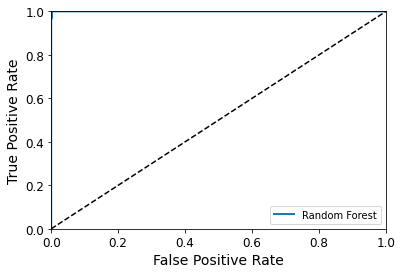

In [21]:
from sklearn.model_selection import cross_val_predict

y_probas_forest = cross_val_predict(forest_clf, train_set, train_set_labels_eyes_closed, cv=3,
                                    method="predict_proba")

from sklearn.metrics import roc_curve
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_set_labels_eyes_closed,y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_set_labels_eyes_closed, y_scores_forest)

0.9999196926477013

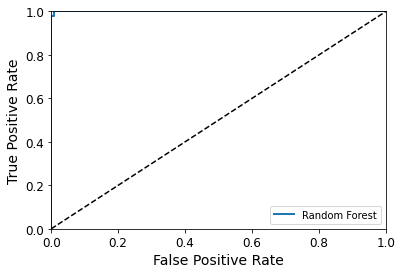

In [23]:
y_probas_forest_test = cross_val_predict(forest_clf, test_set, test_set_labels_eyes_closed, cv=3,
                                    method="predict_proba")

y_scores_forest_test = y_probas_forest_test[:, 1]   # score = proba of positive class
fpr_forest_test2, tpr_forest_test2, thresholds_forest_test2 = roc_curve(test_set_labels_eyes_closed,y_scores_forest_test)

plot_roc_curve(fpr_forest_test2, tpr_forest_test2, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
roc_auc_score(test_set_labels_eyes_closed, y_scores_forest_test)

0.9997968305566843

In [25]:
import joblib

joblib.dump(forest_clf, "mock_eyes_closed_detector_8_2_21.pkl")

['mock_eyes_closed_detector_8_2_21.pkl']